In [1]:
!pip install rdkit-pypi
!pip install openpyxl
!pip install rdkit-pypi avalon_framework

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 42.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for avalon_framework: filename=avalon_framework-1.8.2-py3-none-any.whl size=3868 sha256=29f8418a0215fb26ed7ad35f312ba6270ac7c9922fc581cb33d269852fddd43c
  Stored in directory: /root/.cache/pip/wheels/19/a3/86/e8991278ac56c74bdc9382f08c2790b5c3bbcd8ea5c08f9a90
Successfully built avalon_framework


In [3]:
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
#from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import learning_curve

<Figure size 800x800 with 0 Axes>

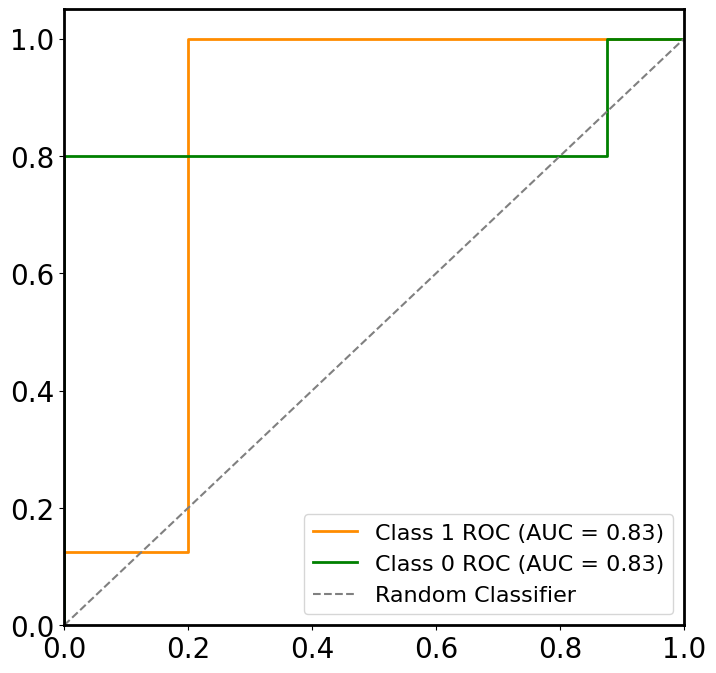

AUC for Class 1 (Positive): 0.8250
AUC for Class 0 (Negative): 0.8250
Best model index: 20
Best F1 score: 0.9412


In [5]:
# Set seed for reproducibility
seed_value = 45
np.random.seed(seed_value)
# Load the Excel file
df = pd.read_excel('HOMO-LUMO-energies.xlsx')  # Replace with actual file path

# Define column names for better clarity
column_names = ["Cmpd Lab", "Smiles", "dFF", "HOMO (eV)", "LUMO (eV)"]
df.columns = column_names
smiles_list = df["Smiles"]
# Create 'Class' column based on dFF values
df["Class"] = (df["dFF"] > 0.3).astype(int)

# Scatter plot: dFF vs Molecules, colored by Class
plt.figure(figsize=(8, 8))
molecule_indices = range(len(df))
colors = df["Class"].map({0: 'red', 1: 'blue'})  # Color based on Class (0 = red, 1 = blue)

# === Generate Morgan fingerprints ===
mols = [Chem.MolFromSmiles(sm) for sm in smiles_list]
fingerprints = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048) for mol in mols]
fingerprints_array = np.array([np.array(fp) for fp in fingerprints])  # Convert RDKit bit vectors to NumPy array

# === Initialize tracking ===
metrics_list = []
confusion_matrix_list = []
best_model_index = -1
best_f1_score = -1
best_model = None
best_x_test = None
best_y_test = None
best_y_prob = None

# === Train and evaluate 200 SVM models ===
num_models = 200

for i in range(num_models):
    # Shuffle and split
    permutation = np.random.permutation(len(fingerprints_array))
    shuffled_features = fingerprints_array[permutation]
    shuffled_labels = df["Class"][permutation]  # Assumed 'df["Class"]' contains the labels

    x_train, x_test, y_train, y_test = train_test_split(shuffled_features, shuffled_labels, test_size=0.20, random_state=i)

    # Train SVC
    model = SVC(kernel='linear', probability=True)
    model.fit(x_train, y_train)

    # Predict
    y_pred = model.predict(x_test)
    y_prob = model.predict_proba(x_test)

    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    fpr1, tpr1, _ = roc_curve(y_test, y_prob[:, 1])
    auc1 = auc(fpr1, tpr1)

    # Skip perfect models
    if acc == 1 or f1 == 1 or auc1 == 1:
       continue

    metrics_list.append({
        "Model": i + 1,
        "Accuracy": acc,
        "F1 Score": f1,
        "Recall": recall,
        "AUC": auc1
    })
    confusion_matrix_list.append(cm)

    if f1 > best_f1_score:
        best_f1_score = f1
        best_model_index = i
        best_model = model
        best_x_test = x_test
        best_y_test = y_test
        best_y_prob = y_prob

# === Save metrics ===
metrics_df = pd.DataFrame(metrics_list)
metrics_df.to_csv("metrics_morgan_only.csv", index=False)

# === ROC for best model ===
y_prob = best_model.predict_proba(best_x_test)
fpr1, tpr1, _ = roc_curve(best_y_test, y_prob[:, 1])
auc1 = auc(fpr1, tpr1)

fpr0, tpr0, _ = roc_curve(best_y_test, y_prob[:, 0], pos_label=0)
auc0 = auc(fpr0, tpr0)

# === Plot ROC ===
plt.figure(figsize=(8, 8))
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label=f'Class 1 ROC (AUC = {auc1:.2f})')
plt.plot(fpr0, tpr0, color='green', lw=2, label=f'Class 0 ROC (AUC = {auc0:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tick_params(axis='both', which='major', labelsize=20)

ax = plt.gca()
for side in ['top', 'right', 'bottom', 'left']:
    ax.spines[side].set_linewidth(2)

plt.legend(loc="lower right", fontsize=16)
plt.savefig("roc_morgan_only.png", dpi=300)
plt.show()

# === Print Summary ===
print(f"AUC for Class 1 (Positive): {auc1:.4f}")
print(f"AUC for Class 0 (Negative): {auc0:.4f}")
print(f"Best model index: {best_model_index + 1}")
print(f"Best F1 score: {best_f1_score:.4f}")


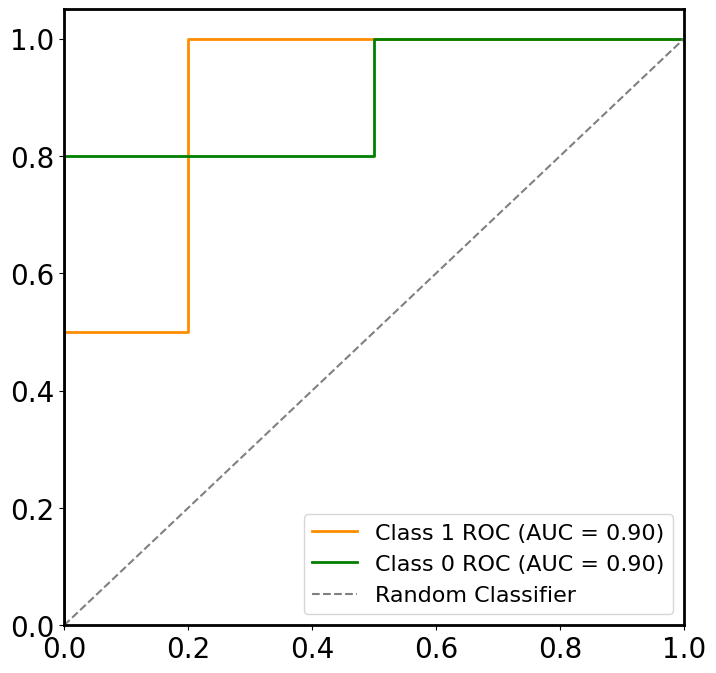

AUC for Class 1 (Positive): 0.9000
AUC for Class 0 (Negative): 0.9000
Best model index: 37
Best F1 score: 0.9412


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_curve, auc, confusion_matrix

# Set seed for reproducibility
seed_value = 45
np.random.seed(seed_value)

# === Load the Excel file ===
df = pd.read_excel('HOMO-LUMO-energies.xlsx')  # Just using SMILES and dFF
df.columns = ["Cmpd Lab", "Smiles", "dFF", "HOMO (eV)", "LUMO (eV)"]

# === Create 'Class' column based on dFF threshold ===
df["Class"] = (df["dFF"] > 0.3).astype(int)

# === Generate MACCS fingerprints ===
smiles_list = df["Smiles"]
mols = [Chem.MolFromSmiles(sm) for sm in smiles_list]
MACCS_fingerprints = [MACCSkeys.GenMACCSKeys(mol) for mol in mols]
fingerprints_array = np.array([np.array(fp) for fp in MACCS_fingerprints])  # Convert RDKit bit vectors to NumPy array

# === Initialize tracking ===
metrics_list = []
confusion_matrix_list = []
best_model_index = -1
best_f1_score = -1
best_model = None
best_x_test = None
best_y_test = None
best_y_prob = None

# === Train and evaluate 200 SVM models ===
num_models = 200

for i in range(num_models):
    # Shuffle and split
    permutation = np.random.permutation(len(fingerprints_array))
    shuffled_features = fingerprints_array[permutation]
    shuffled_labels = df["Class"].values[permutation]

    x_train, x_test, y_train, y_test = train_test_split(shuffled_features, shuffled_labels, test_size=0.20, random_state=i)

    # Train SVC with linear kernel
    model = SVC(kernel='linear', probability=True)
    model.fit(x_train, y_train)

    # Predict
    y_pred = model.predict(x_test)
    y_prob = model.predict_proba(x_test)

    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    fpr1, tpr1, _ = roc_curve(y_test, y_prob[:, 1])
    auc1 = auc(fpr1, tpr1)

    # Skip perfect models
    if acc == 1 or f1 == 1 or auc1 == 1:
        continue

    metrics_list.append({
        "Model": i + 1,
        "Accuracy": acc,
        "F1 Score": f1,
        "Recall": recall,
        "AUC": auc1
    })
    confusion_matrix_list.append(cm)

    if f1 > best_f1_score:
        best_f1_score = f1
        best_model_index = i
        best_model = model
        best_x_test = x_test
        best_y_test = y_test
        best_y_prob = y_prob

# === Save metrics to CSV ===
metrics_df = pd.DataFrame(metrics_list)
metrics_df.to_csv("metrics_maccs_only.csv", index=False)

# === ROC for best model ===
y_prob = best_model.predict_proba(best_x_test)
fpr1, tpr1, _ = roc_curve(best_y_test, y_prob[:, 1])
auc1 = auc(fpr1, tpr1)

fpr0, tpr0, _ = roc_curve(best_y_test, y_prob[:, 0], pos_label=0)
auc0 = auc(fpr0, tpr0)

# === Plot ROC ===
plt.figure(figsize=(8, 8))
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label=f'Class 1 ROC (AUC = {auc1:.2f})')
plt.plot(fpr0, tpr0, color='green', lw=2, label=f'Class 0 ROC (AUC = {auc0:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tick_params(axis='both', which='major', labelsize=20)

ax = plt.gca()
for side in ['top', 'right', 'bottom', 'left']:
    ax.spines[side].set_linewidth(2)

plt.legend(loc="lower right", fontsize=16)
plt.savefig("roc_maccs_only.png", dpi=300)
plt.show()

# === Print Summary ===
print(f"AUC for Class 1 (Positive): {auc1:.4f}")
print(f"AUC for Class 0 (Negative): {auc0:.4f}")
print(f"Best model index: {best_model_index + 1}")
print(f"Best F1 score: {best_f1_score:.4f}")


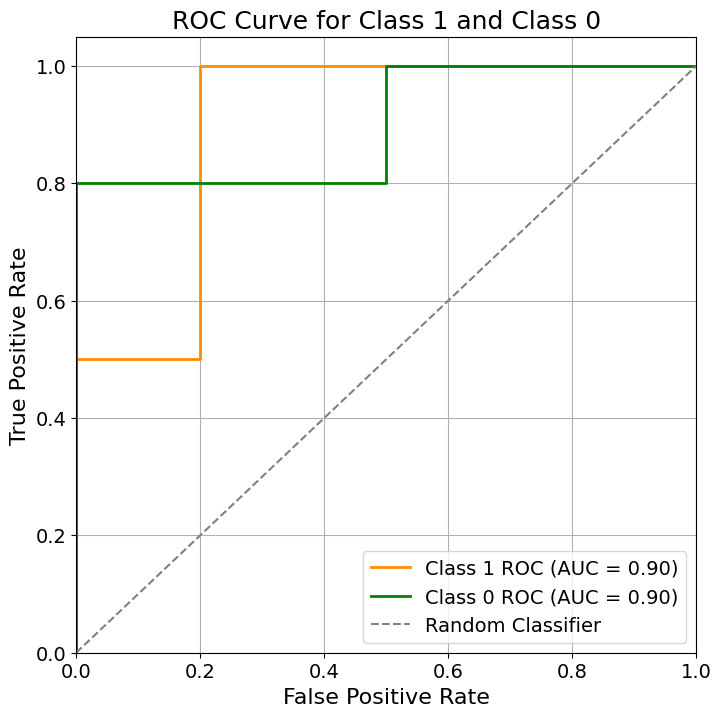

AUC for Class 1 (Positive): 0.9000
AUC for Class 0 (Negative): 0.9000
Best model index: 37
Best F1 score: 0.9412


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_curve, auc, confusion_matrix

# Set seed for reproducibility
seed_value = 45
np.random.seed(seed_value)

# === Load the Excel file ===
df = pd.read_excel('HOMO-LUMO-energies.xlsx')
df.columns = ["Cmpd Lab", "Smiles", "dFF", "HOMO (eV)", "LUMO (eV)"]

# === Create binary class based on dFF threshold ===
df["Class"] = (df["dFF"] > 0.3).astype(int)

# === Generate MACCS fingerprints ===
smiles_list = df["Smiles"]
mols = [Chem.MolFromSmiles(sm) for sm in smiles_list]
fingerprints = [MACCSkeys.GenMACCSKeys(mol) for mol in mols]
fingerprints_array = np.array([np.array(fp) for fp in fingerprints])  # RDKit bit vectors → NumPy array

# === Initialize tracking ===
metrics_list = []
confusion_matrix_list = []
best_model_index = -1
best_f1_score = -1
best_model = None
best_x_test = None
best_y_test = None
best_y_prob = None

# === Train and evaluate 200 SVM models ===
num_models = 200

for i in range(num_models):
    permutation = np.random.permutation(len(fingerprints_array))
    shuffled_features = fingerprints_array[permutation]
    shuffled_labels = df["Class"].values[permutation]

    x_train, x_test, y_train, y_test = train_test_split(
        shuffled_features, shuffled_labels, test_size=0.20, random_state=i
    )

    model = SVC(kernel='linear', probability=True)
    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)
    y_prob = model.predict_proba(x_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    fpr1, tpr1, _ = roc_curve(y_test, y_prob[:, 1])
    auc1 = auc(fpr1, tpr1)

    # Filter: high but not perfect
    if f1 < 1.0 and acc < 1.0 and auc1 < 1.0 and f1 > 0.85:
        metrics_list.append({
            "Model": i + 1,
            "Accuracy": acc,
            "F1 Score": f1,
            "Recall": recall,
            "AUC": auc1
        })
        confusion_matrix_list.append(cm)

        if f1 > best_f1_score:
            best_f1_score = f1
            best_model_index = i
            best_model = model
            best_x_test = x_test
            best_y_test = y_test
            best_y_prob = y_prob

# === Save metrics to CSV ===
metrics_df = pd.DataFrame(metrics_list)
metrics_df.to_csv("metrics_maccs_only_high_but_not_perfect.csv", index=False)

# === ROC for best model ===
y_prob = best_model.predict_proba(best_x_test)

# Class 1 (positive class)
fpr1, tpr1, _ = roc_curve(best_y_test, y_prob[:, 1])
auc1 = auc(fpr1, tpr1)

# Class 0 (negative class)
fpr0, tpr0, _ = roc_curve(best_y_test, y_prob[:, 0], pos_label=0)
auc0 = auc(fpr0, tpr0)

# === Pad ROC arrays to match lengths
max_len = max(len(fpr1), len(fpr0))
fpr1 = np.pad(fpr1, (0, max_len - len(fpr1)), constant_values=np.nan)
tpr1 = np.pad(tpr1, (0, max_len - len(tpr1)), constant_values=np.nan)
fpr0 = np.pad(fpr0, (0, max_len - len(fpr0)), constant_values=np.nan)
tpr0 = np.pad(tpr0, (0, max_len - len(tpr0)), constant_values=np.nan)

# === Save ROC data for Origin ===
roc_data_df = pd.DataFrame({
    "FPR_Class1": fpr1,
    "TPR_Class1": tpr1,
    "FPR_Class0": fpr0,
    "TPR_Class0": tpr0
})
roc_data_df.to_csv("roc_curve_data_for_origin.csv", index=False)

# === Save AUC and summary info ===
with open("roc_auc_info.txt", "w") as f:
    f.write(f"AUC (Class 1) = {auc1:.4f}\n")
    f.write(f"AUC (Class 0) = {auc0:.4f}\n")
    f.write(f"Best Model Index = {best_model_index + 1}\n")
    f.write(f"Best F1 Score = {best_f1_score:.4f}\n")

# === Plot ROC in Python (optional preview) ===
plt.figure(figsize=(8, 8))
plt.plot(fpr1, tpr1, label=f"Class 1 ROC (AUC = {auc1:.2f})", lw=2, color='darkorange')
plt.plot(fpr0, tpr0, label=f"Class 0 ROC (AUC = {auc0:.2f})", lw=2, color='green')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)
plt.title("ROC Curve for Class 1 and Class 0", fontsize=18)
plt.tick_params(axis='both', labelsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.grid(True)
plt.savefig("roc_curve_class1_class0.png", dpi=300)
plt.show()

# === Print Summary ===
print(f"AUC for Class 1 (Positive): {auc1:.4f}")
print(f"AUC for Class 0 (Negative): {auc0:.4f}")
print(f"Best model index: {best_model_index + 1}")
print(f"Best F1 score: {best_f1_score:.4f}")


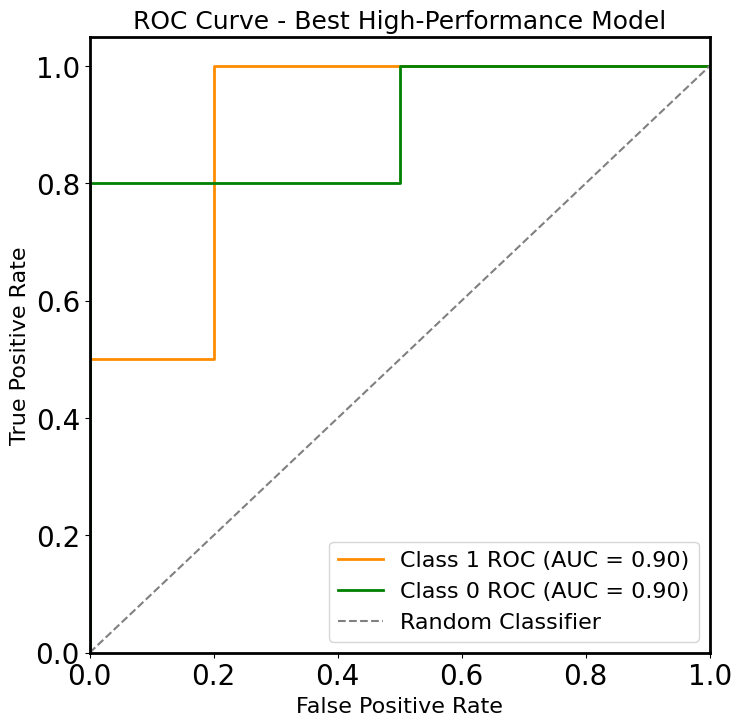

AUC for Class 1 (Positive): 0.9000
AUC for Class 0 (Negative): 0.9000
Best model index: 37
Best F1 score: 0.9412


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_curve, auc, confusion_matrix

# Set seed for reproducibility
seed_value = 45
np.random.seed(seed_value)

# === Load the Excel file ===
df = pd.read_excel('HOMO-LUMO-energies.xlsx')  # Adjust path if needed
df.columns = ["Cmpd Lab", "Smiles", "dFF", "HOMO (eV)", "LUMO (eV)"]

# === Create 'Class' column based on dFF threshold ===
df["Class"] = (df["dFF"] > 0.3).astype(int)

# === Generate MACCS fingerprints ===
smiles_list = df["Smiles"]
mols = [Chem.MolFromSmiles(sm) for sm in smiles_list]
fingerprints = [MACCSkeys.GenMACCSKeys(mol) for mol in mols]
fingerprints_array = np.array([np.array(fp) for fp in fingerprints])  # Convert RDKit bit vectors to NumPy array

# === Initialize tracking ===
metrics_list = []
confusion_matrix_list = []
best_model_index = -1
best_f1_score = -1
best_model = None
best_x_test = None
best_y_test = None
best_y_prob = None

# === Train and evaluate 200 SVM models ===
num_models = 200

for i in range(num_models):
    permutation = np.random.permutation(len(fingerprints_array))
    shuffled_features = fingerprints_array[permutation]
    shuffled_labels = df["Class"].values[permutation]

    x_train, x_test, y_train, y_test = train_test_split(
        shuffled_features, shuffled_labels, test_size=0.20, random_state=i
    )

    model = SVC(kernel='linear', probability=True)
    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)
    y_prob = model.predict_proba(x_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    fpr1, tpr1, _ = roc_curve(y_test, y_prob[:, 1])
    auc1 = auc(fpr1, tpr1)

    # Keep only high-performing but not perfect models
    if f1 < 1.0 and acc < 1.0 and auc1 < 1.0 and f1 > 0.85:
        metrics_list.append({
            "Model": i + 1,
            "Accuracy": acc,
            "F1 Score": f1,
            "Recall": recall,
            "AUC": auc1
        })
        confusion_matrix_list.append(cm)

        if f1 > best_f1_score:
            best_f1_score = f1
            best_model_index = i
            best_model = model
            best_x_test = x_test
            best_y_test = y_test
            best_y_prob = y_prob

# === Save metrics ===
metrics_df = pd.DataFrame(metrics_list)
metrics_df.to_csv("metrics_maccs_only_high_but_not_perfect.csv", index=False)

# === ROC for best model ===
y_prob = best_model.predict_proba(best_x_test)
fpr1, tpr1, _ = roc_curve(best_y_test, y_prob[:, 1])
auc1 = auc(fpr1, tpr1)

fpr0, tpr0, _ = roc_curve(best_y_test, y_prob[:, 0], pos_label=0)
auc0 = auc(fpr0, tpr0)

# === Save ROC data for Origin ===
roc_data_df = pd.DataFrame({
    "FPR": fpr1,
    "TPR": tpr1
})
roc_data_df.to_csv("roc_curve_data_for_origin.csv", index=False)

# === Save AUC to text file for Origin annotation ===
with open("roc_auc_info.txt", "w") as f:
    f.write(f"AUC (Class 1) = {auc1:.4f}\n")
    f.write(f"AUC (Class 0) = {auc0:.4f}\n")
    f.write(f"Best Model Index = {best_model_index + 1}\n")
    f.write(f"Best F1 Score = {best_f1_score:.4f}\n")

# === Plot ROC ===
plt.figure(figsize=(8, 8))
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label=f'Class 1 ROC (AUC = {auc1:.2f})')
plt.plot(fpr0, tpr0, color='green', lw=2, label=f'Class 0 ROC (AUC = {auc0:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)

ax = plt.gca()
for side in ['top', 'right', 'bottom', 'left']:
    ax.spines[side].set_linewidth(2)

plt.legend(loc="lower right", fontsize=16)
plt.title("ROC Curve - Best High-Performance Model", fontsize=18)
plt.savefig("roc_maccs_only_high_but_not_perfect.png", dpi=300)
plt.show()

# === Print Summary ===
print(f"AUC for Class 1 (Positive): {auc1:.4f}")
print(f"AUC for Class 0 (Negative): {auc0:.4f}")
print(f"Best model index: {best_model_index + 1}")
print(f"Best F1 score: {best_f1_score:.4f}")



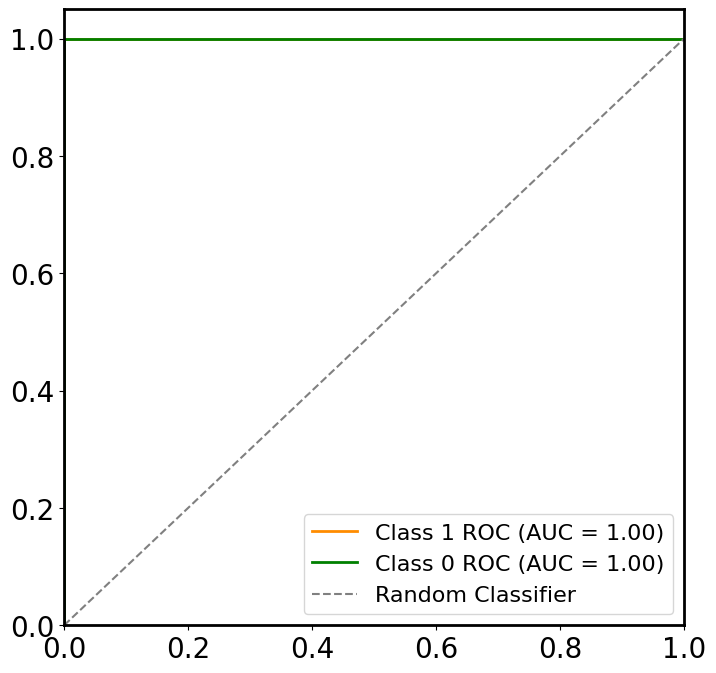

AUC for Class 1 (Positive): 1.0000
AUC for Class 0 (Negative): 1.0000
Best model index: 17
Best F1 score: 1.0000


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import rdmolops
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_curve, auc, confusion_matrix

# === Set seed for reproducibility ===
seed_value = 45
np.random.seed(seed_value)

# === Load the Excel file ===
df = pd.read_excel('HOMO-LUMO-energies.xlsx')

# Rename columns for clarity
df.columns = ["Cmpd Lab", "Smiles", "dFF", "HOMO (eV)", "LUMO (eV)"]

# Create binary class labels from dFF
df["Class"] = (df["dFF"] > 0.3).astype(int)

# === Generate Daylight-like (RDKit) fingerprints ===
smiles_list = df["Smiles"]
mols = [Chem.MolFromSmiles(sm) for sm in smiles_list]
fingerprints = [Chem.RDKFingerprint(mol, fpSize=2048) for mol in mols]
fingerprints_array = np.array([np.array(fp) for fp in fingerprints])  # Convert to NumPy array

# === Initialize tracking variables ===
metrics_list = []
confusion_matrix_list = []
best_model_index = -1
best_f1_score = -1
best_model = None
best_x_test = None
best_y_test = None
best_y_prob = None

# === Train and evaluate 200 models ===
num_models = 200

for i in range(num_models):
    # Shuffle and split
    permutation = np.random.permutation(len(fingerprints_array))
    shuffled_features = fingerprints_array[permutation]
    shuffled_labels = df["Class"].values[permutation]

    x_train, x_test, y_train, y_test = train_test_split(shuffled_features, shuffled_labels, test_size=0.20, random_state=i)

    # Train SVC
    model = SVC(kernel='linear', probability=True)
    model.fit(x_train, y_train)

    # Predict
    y_pred = model.predict(x_test)
    y_prob = model.predict_proba(x_test)

    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    fpr1, tpr1, _ = roc_curve(y_test, y_prob[:, 1])
    auc1 = auc(fpr1, tpr1)

    # Skip perfect models
    #if acc == 1 or f1 == 1 or auc1 == 1:
     #   continue

    metrics_list.append({
        "Model": i + 1,
        "Accuracy": acc,
        "F1 Score": f1,
        "Recall": recall,
        "AUC": auc1
    })
    confusion_matrix_list.append(cm)

    if f1 > best_f1_score:
        best_f1_score = f1
        best_model_index = i
        best_model = model
        best_x_test = x_test
        best_y_test = y_test
        best_y_prob = y_prob

# === Save metrics to CSV ===
metrics_df = pd.DataFrame(metrics_list)
metrics_df.to_csv("metrics_daylight_like.csv", index=False)

# === ROC for best model ===
y_prob = best_model.predict_proba(best_x_test)
fpr1, tpr1, _ = roc_curve(best_y_test, y_prob[:, 1])
auc1 = auc(fpr1, tpr1)

fpr0, tpr0, _ = roc_curve(best_y_test, y_prob[:, 0], pos_label=0)
auc0 = auc(fpr0, tpr0)

# === Plot ROC curves ===
plt.figure(figsize=(8, 8))
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label=f'Class 1 ROC (AUC = {auc1:.2f})')
plt.plot(fpr0, tpr0, color='green', lw=2, label=f'Class 0 ROC (AUC = {auc0:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tick_params(axis='both', which='major', labelsize=20)

ax = plt.gca()
for side in ['top', 'right', 'bottom', 'left']:
    ax.spines[side].set_linewidth(2)

plt.legend(loc="lower right", fontsize=16)
plt.savefig("roc_daylight_like.png", dpi=300)
plt.show()

# === Print Summary ===
print(f"AUC for Class 1 (Positive): {auc1:.4f}")
print(f"AUC for Class 0 (Negative): {auc0:.4f}")
print(f"Best model index: {best_model_index + 1}")
print(f"Best F1 score: {best_f1_score:.4f}")


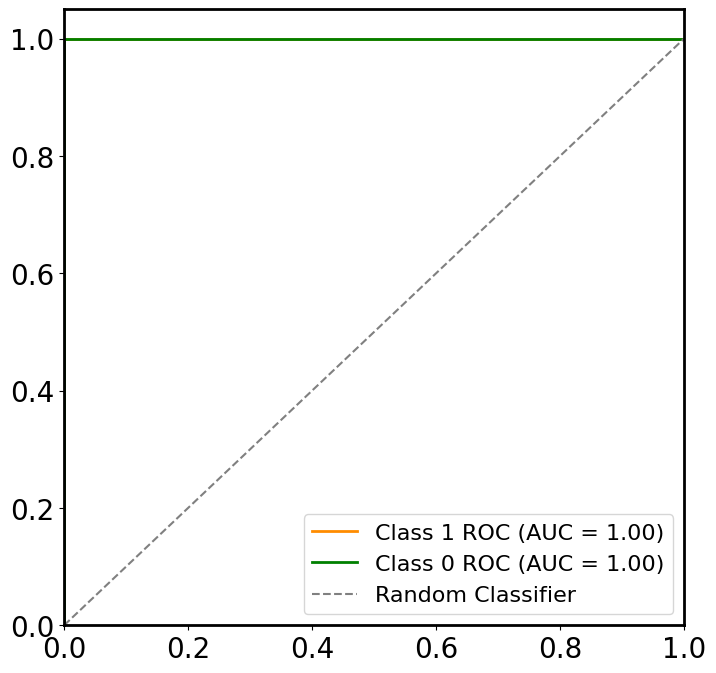

AUC for Class 1 (Positive): 1.0000
AUC for Class 0 (Negative): 1.0000
Best model index: 25
Best F1 score: 1.0000


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_curve, auc, confusion_matrix

# === Set seed for reproducibility ===
seed_value = 45
np.random.seed(seed_value)

# === Load the Excel file ===
df = pd.read_excel('HOMO-LUMO-energies.xlsx')

# Rename columns for clarity
df.columns = ["Cmpd Lab", "Smiles", "dFF", "HOMO (eV)", "LUMO (eV)"]

# Create binary class labels from dFF
df["Class"] = (df["dFF"] > 0.3).astype(int)

# === Generate AtomPairs fingerprints ===
smiles_list = df["Smiles"]
mols = [Chem.MolFromSmiles(sm) for sm in smiles_list]
atompairs_fingerprints = [AllChem.GetHashedAtomPairFingerprintAsBitVect(mol) for mol in mols]
fingerprints_array = np.array([np.array(fp) for fp in atompairs_fingerprints])  # Convert to NumPy array

# === Initialize tracking variables ===
metrics_list = []
confusion_matrix_list = []
best_model_index = -1
best_f1_score = -1
best_model = None
best_x_test = None
best_y_test = None
best_y_prob = None

# === Train and evaluate 200 models ===
num_models = 200

for i in range(num_models):
    # Shuffle and split
    permutation = np.random.permutation(len(fingerprints_array))
    shuffled_features = fingerprints_array[permutation]
    shuffled_labels = df["Class"].values[permutation]

    x_train, x_test, y_train, y_test = train_test_split(shuffled_features, shuffled_labels, test_size=0.20, random_state=i)

    # Train SVC
    model = SVC(kernel='linear', probability=True)
    model.fit(x_train, y_train)

    # Predict
    y_pred = model.predict(x_test)
    y_prob = model.predict_proba(x_test)

    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    fpr1, tpr1, _ = roc_curve(y_test, y_prob[:, 1])
    auc1 = auc(fpr1, tpr1)

    # Skip perfect models
    #if acc == 1 or f1 == 1 or auc1 == 1:
      #  continue

    metrics_list.append({
        "Model": i + 1,
        "Accuracy": acc,
        "F1 Score": f1,
        "Recall": recall,
        "AUC": auc1
    })
    confusion_matrix_list.append(cm)

    if f1 > best_f1_score:
        best_f1_score = f1
        best_model_index = i
        best_model = model
        best_x_test = x_test
        best_y_test = y_test
        best_y_prob = y_prob

# === Save metrics to CSV ===
metrics_df = pd.DataFrame(metrics_list)
metrics_df.to_csv("metrics_atompairs_only.csv", index=False)

# === ROC for best model ===
y_prob = best_model.predict_proba(best_x_test)
fpr1, tpr1, _ = roc_curve(best_y_test, y_prob[:, 1])
auc1 = auc(fpr1, tpr1)

fpr0, tpr0, _ = roc_curve(best_y_test, y_prob[:, 0], pos_label=0)
auc0 = auc(fpr0, tpr0)

# === Plot ROC curves ===
plt.figure(figsize=(8, 8))
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label=f'Class 1 ROC (AUC = {auc1:.2f})')
plt.plot(fpr0, tpr0, color='green', lw=2, label=f'Class 0 ROC (AUC = {auc0:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tick_params(axis='both', which='major', labelsize=20)

ax = plt.gca()
for side in ['top', 'right', 'bottom', 'left']:
    ax.spines[side].set_linewidth(2)

plt.legend(loc="lower right", fontsize=16)
plt.savefig("roc_atompairs_only.png", dpi=300)
plt.show()

# === Print Summary ===
print(f"AUC for Class 1 (Positive): {auc1:.4f}")
print(f"AUC for Class 0 (Negative): {auc0:.4f}")
print(f"Best model index: {best_model_index + 1}")
print(f"Best F1 score: {best_f1_score:.4f}")


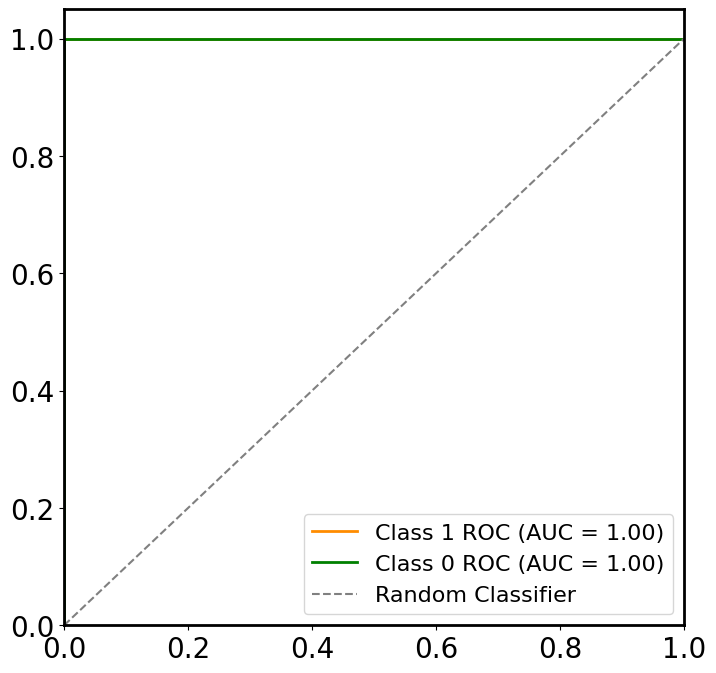

AUC for Class 1 (Positive): 1.0000
AUC for Class 0 (Negative): 1.0000
Best model index: 11
Best F1 score: 1.0000


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_curve, auc, confusion_matrix

# === Set seed for reproducibility ===
seed_value = 45
np.random.seed(seed_value)

# === Load the Excel file ===
df = pd.read_excel('HOMO-LUMO-energies.xlsx')

# Rename columns for clarity
df.columns = ["Cmpd Lab", "Smiles", "dFF", "HOMO (eV)", "LUMO (eV)"]

# Create binary class labels from dFF
df["Class"] = (df["dFF"] > 0.3).astype(int)

# === Generate Topological Torsion fingerprints ===
smiles_list = df["Smiles"]
mols = [Chem.MolFromSmiles(sm) for sm in smiles_list]
torsion_fingerprints = [AllChem.GetHashedTopologicalTorsionFingerprintAsBitVect(mol, nBits=2048) for mol in mols]
fingerprints_array = np.array([np.array(fp) for fp in torsion_fingerprints])  # Convert to NumPy array

# === Initialize tracking variables ===
metrics_list = []
confusion_matrix_list = []
best_model_index = -1
best_f1_score = -1
best_model = None
best_x_test = None
best_y_test = None
best_y_prob = None

# === Train and evaluate 200 models ===
num_models = 200

for i in range(num_models):
    # Shuffle and split
    permutation = np.random.permutation(len(fingerprints_array))
    shuffled_features = fingerprints_array[permutation]
    shuffled_labels = df["Class"].values[permutation]

    x_train, x_test, y_train, y_test = train_test_split(shuffled_features, shuffled_labels, test_size=0.20, random_state=i)

    # Train SVC
    model = SVC(kernel='linear', probability=True)
    model.fit(x_train, y_train)

    # Predict
    y_pred = model.predict(x_test)
    y_prob = model.predict_proba(x_test)

    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    fpr1, tpr1, _ = roc_curve(y_test, y_prob[:, 1])
    auc1 = auc(fpr1, tpr1)

    # Skip perfect models
    #if acc == 1 or f1 == 1 or auc1 == 1:
     #   continue

    metrics_list.append({
        "Model": i + 1,
        "Accuracy": acc,
        "F1 Score": f1,
        "Recall": recall,
        "AUC": auc1
    })
    confusion_matrix_list.append(cm)

    if f1 > best_f1_score:
        best_f1_score = f1
        best_model_index = i
        best_model = model
        best_x_test = x_test
        best_y_test = y_test
        best_y_prob = y_prob

# === Save metrics to CSV ===
metrics_df = pd.DataFrame(metrics_list)
metrics_df.to_csv("metrics_torsion_only.csv", index=False)

# === ROC for best model ===
y_prob = best_model.predict_proba(best_x_test)
fpr1, tpr1, _ = roc_curve(best_y_test, y_prob[:, 1])
auc1 = auc(fpr1, tpr1)

fpr0, tpr0, _ = roc_curve(best_y_test, y_prob[:, 0], pos_label=0)
auc0 = auc(fpr0, tpr0)

# === Plot ROC curves ===
plt.figure(figsize=(8, 8))
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label=f'Class 1 ROC (AUC = {auc1:.2f})')
plt.plot(fpr0, tpr0, color='green', lw=2, label=f'Class 0 ROC (AUC = {auc0:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tick_params(axis='both', which='major', labelsize=20)

ax = plt.gca()
for side in ['top', 'right', 'bottom', 'left']:
    ax.spines[side].set_linewidth(2)

plt.legend(loc="lower right", fontsize=16)
plt.savefig("roc_torsion_only.png", dpi=300)
plt.show()

# === Print Summary ===
print(f"AUC for Class 1 (Positive): {auc1:.4f}")
print(f"AUC for Class 0 (Negative): {auc0:.4f}")
print(f"Best model index: {best_model_index + 1}")
print(f"Best F1 score: {best_f1_score:.4f}")


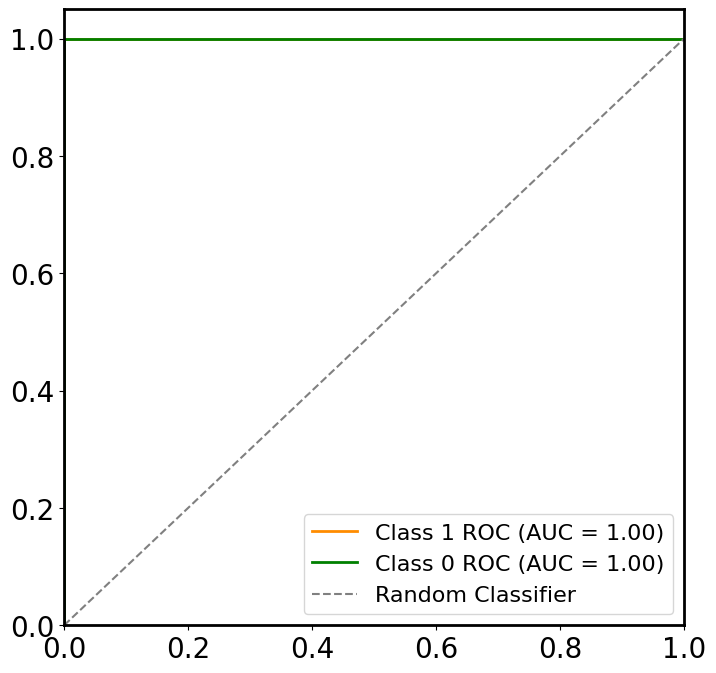

AUC for Class 1 (Positive): 1.0000
AUC for Class 0 (Negative): 1.0000
Best model index: 17
Best F1 score: 1.0000


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Avalon.pyAvalonTools import GetAvalonFP
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_curve, auc, confusion_matrix

# === Set seed for reproducibility ===
seed_value = 45
np.random.seed(seed_value)

# === Load the Excel file ===
df = pd.read_excel('HOMO-LUMO-energies.xlsx')

# Rename columns for clarity
df.columns = ["Cmpd Lab", "Smiles", "dFF", "HOMO (eV)", "LUMO (eV)"]

# Create binary class labels from dFF
df["Class"] = (df["dFF"] > 0.3).astype(int)

# === Generate Avalon fingerprints ===
smiles_list = df["Smiles"]
mols = [Chem.MolFromSmiles(sm) for sm in smiles_list]
avalon_fingerprints = [GetAvalonFP(mol, nBits=2048) for mol in mols]
fingerprints_array = np.array([np.array(fp) for fp in avalon_fingerprints])  # Convert to NumPy array

# === Initialize tracking variables ===
metrics_list = []
confusion_matrix_list = []
best_model_index = -1
best_f1_score = -1
best_model = None
best_x_test = None
best_y_test = None
best_y_prob = None

# === Train and evaluate 200 models ===
num_models = 200

for i in range(num_models):
    # Shuffle and split
    permutation = np.random.permutation(len(fingerprints_array))
    shuffled_features = fingerprints_array[permutation]
    shuffled_labels = df["Class"].values[permutation]

    x_train, x_test, y_train, y_test = train_test_split(shuffled_features, shuffled_labels, test_size=0.20, random_state=i)

    # Train SVC
    model = SVC(kernel='linear', probability=True)
    model.fit(x_train, y_train)

    # Predict
    y_pred = model.predict(x_test)
    y_prob = model.predict_proba(x_test)

    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    fpr1, tpr1, _ = roc_curve(y_test, y_prob[:, 1])
    auc1 = auc(fpr1, tpr1)

    # Skip perfect models
    #if acc == 1 or f1 == 1 or auc1 == 1:
      #  continue

    metrics_list.append({
        "Model": i + 1,
        "Accuracy": acc,
        "F1 Score": f1,
        "Recall": recall,
        "AUC": auc1
    })
    confusion_matrix_list.append(cm)

    if f1 > best_f1_score:
        best_f1_score = f1
        best_model_index = i
        best_model = model
        best_x_test = x_test
        best_y_test = y_test
        best_y_prob = y_prob

# === Save metrics to CSV ===
metrics_df = pd.DataFrame(metrics_list)
metrics_df.to_csv("metrics_avalon_only.csv", index=False)

# === ROC for best model ===
y_prob = best_model.predict_proba(best_x_test)
fpr1, tpr1, _ = roc_curve(best_y_test, y_prob[:, 1])
auc1 = auc(fpr1, tpr1)

fpr0, tpr0, _ = roc_curve(best_y_test, y_prob[:, 0], pos_label=0)
auc0 = auc(fpr0, tpr0)

# === Plot ROC curves ===
plt.figure(figsize=(8, 8))
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label=f'Class 1 ROC (AUC = {auc1:.2f})')
plt.plot(fpr0, tpr0, color='green', lw=2, label=f'Class 0 ROC (AUC = {auc0:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tick_params(axis='both', which='major', labelsize=20)

ax = plt.gca()
for side in ['top', 'right', 'bottom', 'left']:
    ax.spines[side].set_linewidth(2)

plt.legend(loc="lower right", fontsize=16)
plt.savefig("roc_avalon_only.png", dpi=300)
plt.show()

# === Print Summary ===
print(f"AUC for Class 1 (Positive): {auc1:.4f}")
print(f"AUC for Class 0 (Negative): {auc0:.4f}")
print(f"Best model index: {best_model_index + 1}")
print(f"Best F1 score: {best_f1_score:.4f}")
